# Задача

ДЗ делаем по бд orders

В качестве ДЗ сделаем карту поведения пользователей.

Мы обсуждали, что всех пользователей можно разделить, к примеру, на 
- !New (совершили только 1 покупку), 
- Regular (совершили 2 или более на сумму не более стольки-то), 
- Vip (совершили дорогие покупки и достаточно часто), 
- ! Lost (раньше покупали хотя бы раз и с даты последней покупки прошло больше 3 месяцев).

Вся база должна войти в эти гурппы (т.е. каждый пользователь должен попадать только в одну из этих групп).

Задача:
1. Уточнить критерии групп New,Regular,Vip,Lost
2. По состоянию на 1.01.2017 понимаем, кто попадает в какую группу, подсчитываем кол-во пользователей в каждой.
3. По состоянию на 1.02.2017 понимаем, кто вышел из каждой из групп, а кто вошел.
4. Аналогично смотрим состояние на 1.03.2017, понимаем кто вышел из каждой из групп, а кто вошел.
5. В итоге делаем вывод, какая группа уменьшается, какая увеличивается и продумываем, в чем может быть причина.

Присылайте отчет в pdf
*/

# Подготовка

## Подключение библиотек

In [1]:
import pymysql.cursors
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import getpass

## Подключение к базе данных

In [2]:
# password_mysql = getpass.getpass(prompt="Введите пароль от MySQL-сервера: ")
password_mysql = "pass123"
mydb = pymysql.connect(host="127.0.0.1",
                             user='root',
                             password=password_mysql, 
                             db='db_analyt_loc',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
 
print ("connect successful!!")

connect successful!!


In [3]:
def show_tables():
    return pd.read_sql("""SHOW TABLES FROM db_analyt_loc;""", con=mydb)
show_tables()

,Tables_in_db_analyt_loc
0,orders_20190822
1,orders_all
2,time_user_b
3,time_user_ym_s
4,users_for_merg


1. Уточнить критерии групп New,Regular,Vip,Lost


## 2. По состоянию на 1.01.2017 понимаем, кто попадает в какую группу, подсчитываем кол-во пользователей в каждой.

In [4]:
current_db = 'orders_20190822'

In [5]:
date = ['\'2017-01-01\'','\'2017-02-01\'']

In [91]:
%%time
df = pd.read_sql(
    f"""
    SELECT
      *, DATE({date[0]}) AS date
    FROM (
    SELECT 
        user_id,
        TIMESTAMPDIFF(MONTH,MAX(o_date),DATE('2017-12-31')) AS period_from_last_ord,
      ROUND(COUNT(id_o)/TIMESTAMPDIFF(DAY,MIN(o_date),MAX(o_date)),0) AS freq,
      ROUND(AVG(price),2) as avg_price,
      COUNT(id_o) AS orders_per_user
    FROM (SELECT * FROM {current_db} WHERE o_date < {date[0]}) AS o2
    GROUP BY user_id) AS t;
    """, con=mydb)
df.shape

Wall time: 26.2 s


(445092, 6)

In [92]:
%%time
df_2 = pd.read_sql(
    f"""
    SELECT
      *, DATE({date[1]}) AS date
    FROM (
    SELECT 
        user_id,
        TIMESTAMPDIFF(MONTH,MAX(o_date),DATE('2017-12-31')) AS period_from_last_ord,
      ROUND(COUNT(id_o)/TIMESTAMPDIFF(DAY,MIN(o_date),MAX(o_date)),0) AS freq,
      ROUND(AVG(price),2) as avg_price,
      COUNT(id_o) AS orders_per_user
    FROM (SELECT * FROM {current_db} WHERE o_date < {date[1]}) AS o2
    GROUP BY user_id) AS t;
    """, con=mydb)
df_2.shape

Wall time: 19.6 s


(480832, 6)

In [93]:
df = df.append(df_2, ignore_index=True)

In [94]:
df['date'] = pd.to_datetime(df['date'])

---

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925924 entries, 0 to 925923
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               925924 non-null  int64         
 1   period_from_last_ord  925924 non-null  int64         
 2   freq                  196225 non-null  float64       
 3   avg_price             925924 non-null  float64       
 4   orders_per_user       925924 non-null  int64         
 5   date                  925924 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 42.4 MB


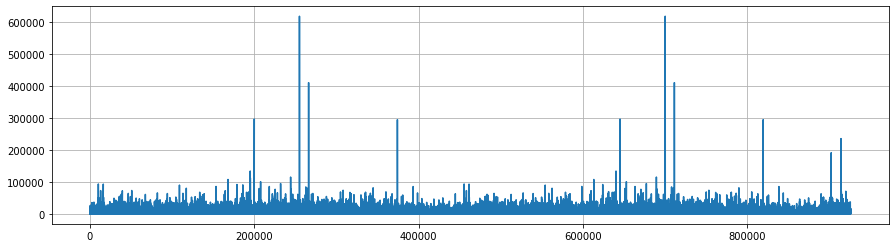

In [96]:
plt.figure(figsize = (15,4))
plt.plot(df.index, df.avg_price)
plt.grid();

In [97]:
# Очистка от личшнего
df = df.drop(df[df["avg_price"] > 150000].index)

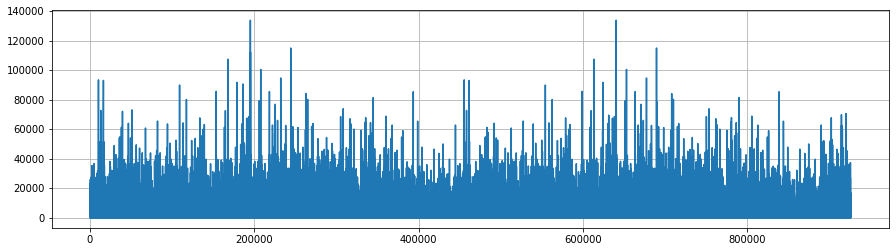

In [98]:
plt.figure(figsize = (15,4))
plt.plot(df.index, df.avg_price)
plt.grid();

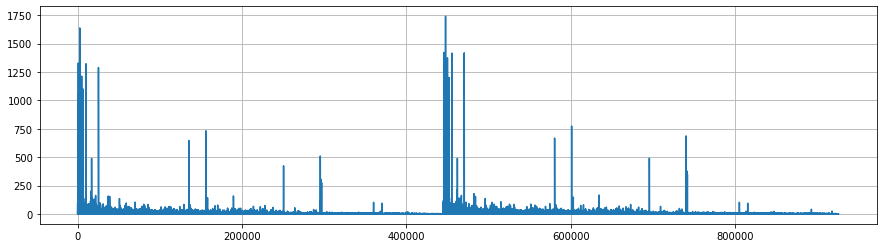

In [99]:
plt.figure(figsize = (15,4))
plt.plot(df.index, df.orders_per_user)
plt.grid();

In [100]:
df[df["orders_per_user"] > 250].shape

(67, 6)

In [101]:
df = df.drop(df[df["orders_per_user"] > 250].index)

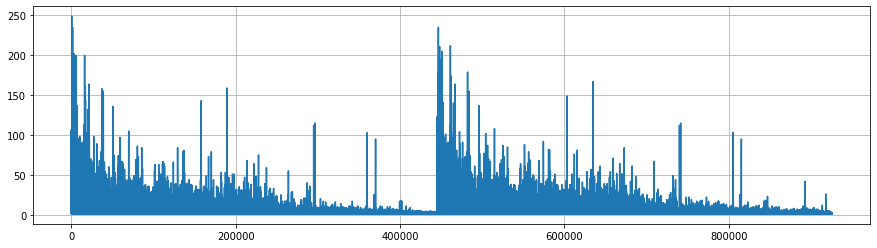

In [102]:
plt.figure(figsize = (15,4))
plt.plot(df.index, df.orders_per_user)
plt.grid();

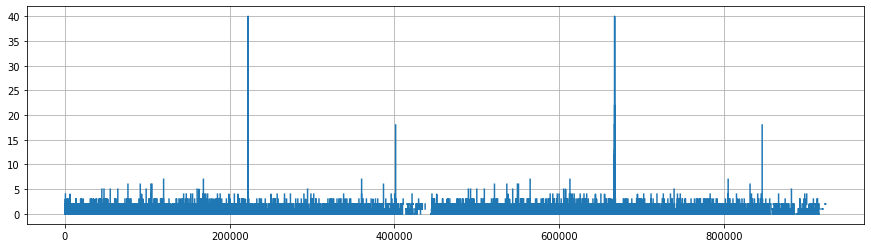

In [108]:
plt.figure(figsize = (15,4))
plt.plot(df.index, df.freq)
plt.grid();

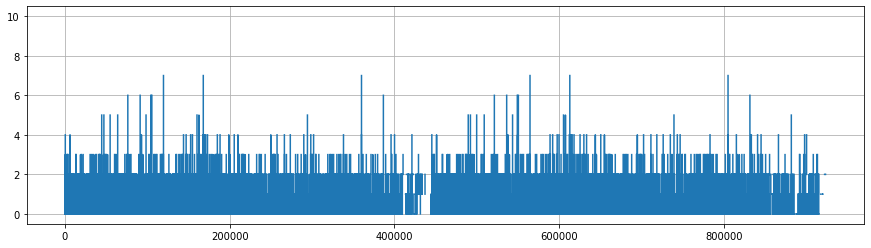

In [109]:
df = df.drop(df[df["freq"] > 10].index)

plt.figure(figsize = (15,4))
plt.plot(df.index, df.freq)
plt.grid();

In [103]:
df.head()

,user_id,period_from_last_ord,freq,avg_price,orders_per_user,date
0,337544,13,0.0,1243.55,2,2017-01-01
1,171642,13,0.0,951.62,22,2017-01-01
2,260596,13,0.0,588.54,9,2017-01-01
3,1105609,23,NaN,752.50,1,2017-01-01
4,982696,23,NaN,4410.00,1,2017-01-01


---

- !New (совершили только 1 покупку)

In [104]:
new = df["orders_per_user"] == 1
df.loc[new, 'group'] = 'New'
df.group.value_counts()

New    694911
Name: group, dtype: int64

- Regular (совершили 2 или более на сумму не более стольки-то), 

In [120]:
regular = (df["orders_per_user"] >= 2) & (df['avg_price'] <= 1000)
df.loc[regular, 'group'] = 'Regular'
df.group.value_counts()

New        694911
Lost       163165
Regular     67751
Name: group, dtype: int64

- Lost (раньше покупали хотя бы раз и с даты последней покупки прошло больше 3 месяцев).

In [119]:
lost = (df["orders_per_user"] > 1) & (df['period_from_last_ord'] > 3)
df.loc[lost, 'group'] = 'Lost'
df.group.value_counts()

New     694911
Lost    230916
Name: group, dtype: int64

- Vip (совершили дорогие покупки и достаточно часто), 

In [121]:
vip = (df['avg_price'] > 1000) & (df['freq'] > 4)
df.loc[vip, 'group'] = 'Vip'
df.group.value_counts()

New        694911
Lost       163103
Regular     67751
Vip            62
Name: group, dtype: int64

---

In [122]:
df.group.value_counts()

New        694911
Lost       163103
Regular     67751
Vip            62
Name: group, dtype: int64

In [ ]:
df

# Закрытие сессии

In [ ]:
mydb.close()